# Dataset and Embedding

TODOs:
- Data exploration plot
- Add larger embedding
- Split training data into train, val, test
- Shuffle training data / Train in batches -> Use dataloader


- Train on more samples


- Schedule learning rates (optional)


- Comments and documentation

In [ ]:
## Imports
import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np
import pickle
import string
import random

## Load data and embedding

In [2]:
# Load data
path_in = './data/'

train = pd.read_csv(path_in + 'train.csv')
#test = pd.read_csv(path_in + 'test.csv')

In [3]:
## Load the saved embedding GloVe with dimension 50
embedding = pickle.load(open("./data/embeddings/GloVe50d.p", "rb") )

## Data exploration

In [ ]:
## Add some fancy plots

## Generate weight matrix

Target dimension: [sequence len, sample, dimension]

In [95]:
seq_len = 45
dimension = 50
number_samples = 10000

#def getWeights(seq_len, dimension, number_samples)
## Initialize matrix
weights = np.zeros((seq_len, number_samples, dimension))
labels = []

## Extract weight matrix for each sample
for sample in range(number_samples):
    sentence = train['question_text'].iloc[sample]
    label = train['target'].iloc[sample]
    labels.append(label)
    
    
    ## Convert to lowercase and split sentence
    sentence = sentence.lower()

    ## Sepearate punctuation
    chs = string.punctuation
    for ch in chs:
        idx = sentence.find(ch)
        
        if idx != -1:
            sentence = sentence.replace(ch, " " + ch)
            
    sentence = sentence.split(' ')   
    
     ## Truncate
    sentence = sentence[0:seq_len]

    ## Find weights
    matrix_len = len(sentence)
    weights_matrix = np.zeros((matrix_len, dimension))
    words_found = 0

    for i, word in enumerate(sentence):
        try: 
            weights_matrix[i] = embedding[word]
            words_found += 1
        except KeyError:
            weights_matrix[i] = np.random.normal(scale=0.6, size=(dimension, ))

    #print("{} / {} words found".format(words_found, len(sentence)))    
    
    ## Pad with zeros to 45
    z = np.zeros((1, dimension))
    
    for i in range(seq_len-matrix_len):      
        weights_matrix = np.concatenate((weights_matrix, z), axis=0)
     
    weights[:, sample, :] = weights_matrix


print("Dimension of weight matrix: {}".format(weights.shape))    
print("Ratio positives/total: {}".format(labels.count(1)/number_samples))


## Convert to torch tensors
weights = torch.tensor(weights)
weights = weights.float()  

labels = torch.tensor(labels).float()

Dimension of weight matrix: (45, 10000, 50)
Ratio positives/total: 0.0637


## Define net

### Net

In [71]:
class Net(nn.Module):
    def __init__(self, hidden_layer_1):
        super(Net, self).__init__()
        self.lstm = nn.LSTM(input_size=50, hidden_size=hidden_layer_1)       
        self.fc1 = nn.Linear(hidden_layer_1, 1)
        self.out = nn.Sigmoid()

    def forward(self, x):        
        output, (h_out, _) = self.lstm(x)        
        output = output[-1, :, :]
        output.squeeze_()     
        x = self.out(self.fc1(output))
        
        return x

## Train the net

In [110]:
### Function for training
epochs = 20
learning_rate = 0.001
momentum = 0.9
hidden_layers = 50
train_size = 4000


net = Net(hidden_layers)
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)
criterion = nn.BCELoss()


## Iterate through all data
loss_list = []
acc_list = []



for epoch in range(epochs):
    print("Epoch {} / {}".format(epoch+1, epochs))
    loss_sub =[]
    acc_sub = []
      
    correct = 0
    
        
    for sample in range(train_size):                 
        ## Get training data
        x = weights[:, sample, :]      
        x.unsqueeze_(1)
        y = labels[sample]
        y = y.view(1)
        
        # Set gradients to zero
        optimizer.zero_grad()
        
        # Forward pass
        output = net(x)
        
        # Evaluate output / compute loss
        loss = criterion(output, y)       
        
        # Backward pass / optimize
        loss.backward()
        
        # Update weights
        optimizer.step()
                
        ## Evaluate
        output = np.where(output.detach().numpy() > 0.5, 1, 0)
        correct += (output == y.numpy()).sum()
        
    acc = correct / train_size
    acc_sub.append(acc)
        
    loss_sub.append(loss.item())
          
        
    acc_list.append(np.mean(acc_sub))   
    loss_list.append(np.mean(loss_sub)) 
    
    #print(loss_list[-1])
    print("Loss: {} | Training accuracy: {}".format(loss_list[-1], acc_list[-1]))

    
print("\nTraining completed!")

Epoch 1 / 20
Loss: 0.06344214081764221 | Training accuracy: 0.934
Epoch 2 / 20
Loss: 0.06258990615606308 | Training accuracy: 0.934
Epoch 3 / 20
Loss: 0.06182772293686867 | Training accuracy: 0.934
Epoch 4 / 20
Loss: 0.06116997450590134 | Training accuracy: 0.934
Epoch 5 / 20
Loss: 0.060525763779878616 | Training accuracy: 0.934
Epoch 6 / 20
Loss: 0.059752628207206726 | Training accuracy: 0.934
Epoch 7 / 20
Loss: 0.05859176814556122 | Training accuracy: 0.934
Epoch 8 / 20
Loss: 0.05638273060321808 | Training accuracy: 0.934
Epoch 9 / 20
Loss: 0.05031564086675644 | Training accuracy: 0.934
Epoch 10 / 20


KeyboardInterrupt: 

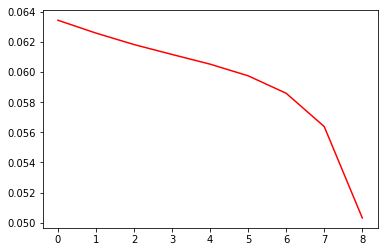

In [111]:
import matplotlib.pyplot as plt

plt.plot(loss_list, color="r")